In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk

from erc.utils import apply_peakl
import torch


def generate_df(train_dataset: load_from_disk,
                valid_dataset: load_from_disk,
                key_list:list,
                ):
    total_dict = {}
    for key_ in key_list:
        
        tmp = pd.concat([pd.DataFrame(train_dataset[key_]),
                        pd.DataFrame(valid_dataset[key_])], axis=0)
        total_dict[key_] = tmp  

    total = pd.concat([total_dict['emotion']], axis=1)

    return total_dict 


def split_before_after(df):
    before_df = df[df['before_after'] == 'before'].drop(["before_after"],axis=1)
    after_df = df[df['before_after'] == 'after'].drop(["before_after"],axis=1)
    return before_df, after_df

idx2emotion = {0: 'Surprise',
 1: 'Fear',
 2: 'Angry',
 3: 'Neutral',
 4: 'Happy',
 5: 'Sad',
 6: 'Disgust'}

# generate dataset 
multi_train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_train0_multilabelTrue_rdeuceFalse")
multi_valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_valid0_multilabelTrue_rdeuceFalse")
train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_train4_multilabelFalse_rdeuceTrue")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_valid4_multilabelFalse_rdeuceTrue")

multi_df = generate_df(multi_train_dataset,
                       multi_valid_dataset,
                       key_list = ["emotion"]
        )
multi_df = pd.concat([multi_df['emotion']], axis=1)
multi_df.columns = [f'E{i}' for i in range(1,7+1)]

In [2]:
perfect= []
for col_name in multi_df.columns:
    n = len(multi_df[multi_df[col_name]==1])
    perfect.append(n)
print(sum(perfect))
print(perfect)

4593
[113, 39, 426, 3531, 316, 168, 0]


In [3]:
multi_df.columns = list(idx2emotion.values())
multi_df['vote_emotion'] = list(multi_train_dataset['vote_emotion'].numpy()) + list(multi_valid_dataset['vote_emotion'].numpy()) 
multi_df['vote_emotion'] = multi_df['vote_emotion'].map(idx2emotion)
multi_df['before_after'] ='before'

In [4]:

peak_df = pd.DataFrame(apply_peakl(torch.from_numpy(multi_df[list(idx2emotion.values())].values)).numpy())
peak_df.columns = list(idx2emotion.values())
peak_df['vote_emotion'] = multi_df['vote_emotion'].values
peak_df['before_after'] = 'after'




merge_df = pd.concat([multi_df, peak_df], axis=0)
merge_df




,Surprise,Fear,Angry,Neutral,Happy,Sad,Disgust,vote_emotion,before_after
0,0.300000,0.0,0.0,0.700000,0.0,0.0,0.000000,Neutral,before
1,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,Neutral,before
2,0.000000,0.0,0.0,0.400000,0.0,0.0,0.600000,Disgust,before
3,0.000000,0.0,0.4,0.400000,0.0,0.0,0.200000,Neutral,before
4,0.000000,0.0,0.1,0.600000,0.0,0.0,0.300000,Neutral,before
...,...,...,...,...,...,...,...,...,...
23453,0.000000,0.0,0.0,0.939436,0.0,0.0,0.060564,Neutral,after
23454,0.379851,0.0,0.0,0.620149,0.0,0.0,0.000000,Neutral,after
23455,0.000000,0.0,0.0,0.939436,0.0,0.0,0.060564,Neutral,after
23456,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,Neutral,after


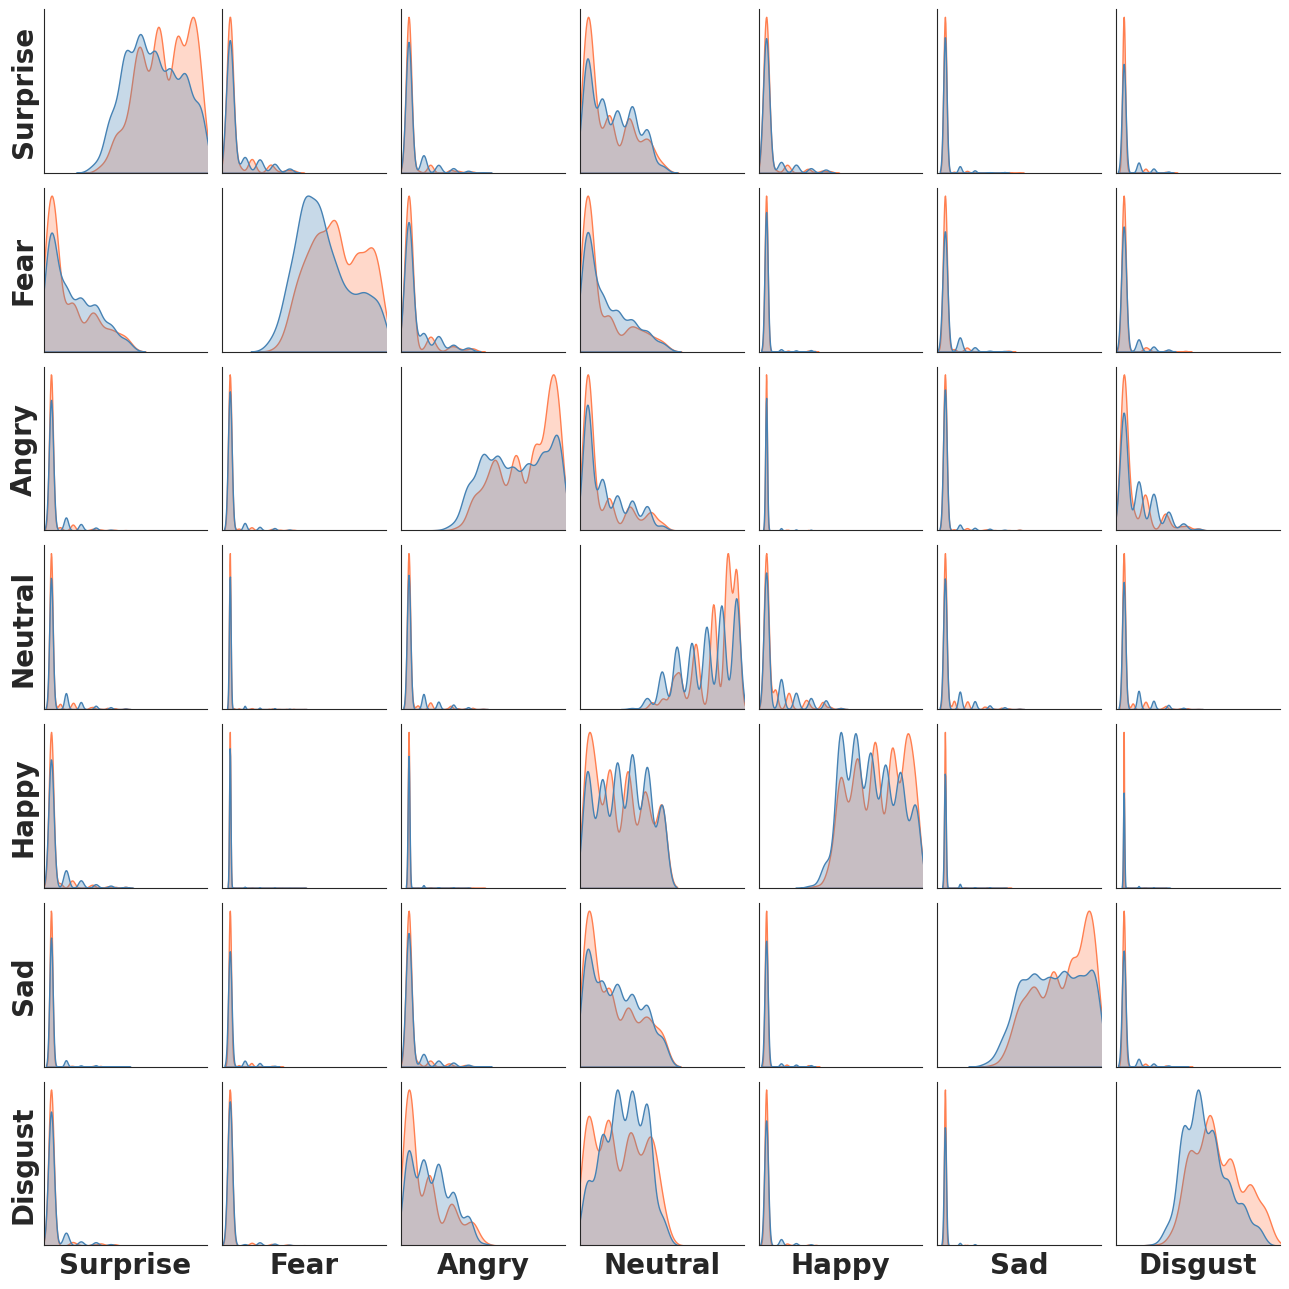

In [5]:
plt.rcParams["font.family"] = "Times New Roman"
sns.set_style("white")
fig, axes = plt.subplots(7, 7, figsize=(13, 13))

for row, row_emotion in  enumerate(list(idx2emotion.values())):
    selected_emotion_df = merge_df[merge_df['vote_emotion'] == row_emotion].drop(['vote_emotion'],axis=1)

    for col, emotion in  enumerate(list(idx2emotion.values())):
        b_ = sns.kdeplot(data=selected_emotion_df,
                         x=emotion,
                          palette=['steelblue', 'coral'],
                          alpha=0.3,
            hue='before_after',
            fill=True, legend=False,
            bw_adjust=1,
            common_norm=True,
            ax=axes[row, col],
            )
        b_.set_xlim(-0.05, 1.05)
        if (col == 0):
            b_.set_ylabel(row_emotion,fontsize=20, fontweight='bold')
        else:
            b_.set_ylabel(None)
        if row== 6:

            b_.set_xlabel(emotion, fontsize=20, fontweight='bold')
        else:
            b_.set_xlabel(None)
        b_.set_xticklabels([])
        b_.set_xticks([])
        b_.set_yticklabels([])
        b_.set_yticks([])


plt.tight_layout()
sns.despine()
# plt.savefig('./etri-fig_ppeak_2.svg')
plt.show()



In [6]:
onehot_df = generate_df(train_dataset,
                        valid_dataset,
                       key_list = ["emotion"]
        )
onehot_df = pd.concat([onehot_df['emotion']], axis=1)

len(onehot_df[onehot_df[0]==3]) / len(onehot_df)

0.6682440959076978

In [7]:
onehot_df = generate_df(train_dataset,
                       valid_dataset,
                       key_list = ['emotion', 'valence','arousal']
        )
onehot_df = pd.concat([onehot_df['emotion'], 
                       onehot_df['valence'],
                       onehot_df['arousal']], axis=1)
onehot_df.columns = ['emotion', 'valence','arousal']
onehot_df['emotion'] = onehot_df['emotion'].map(idx2emotion)

/tmp/ipykernel_1565232/2166772967.py:11: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  ax = sns.scatterplot(x='arousal', y='valence', data=onehot_df,


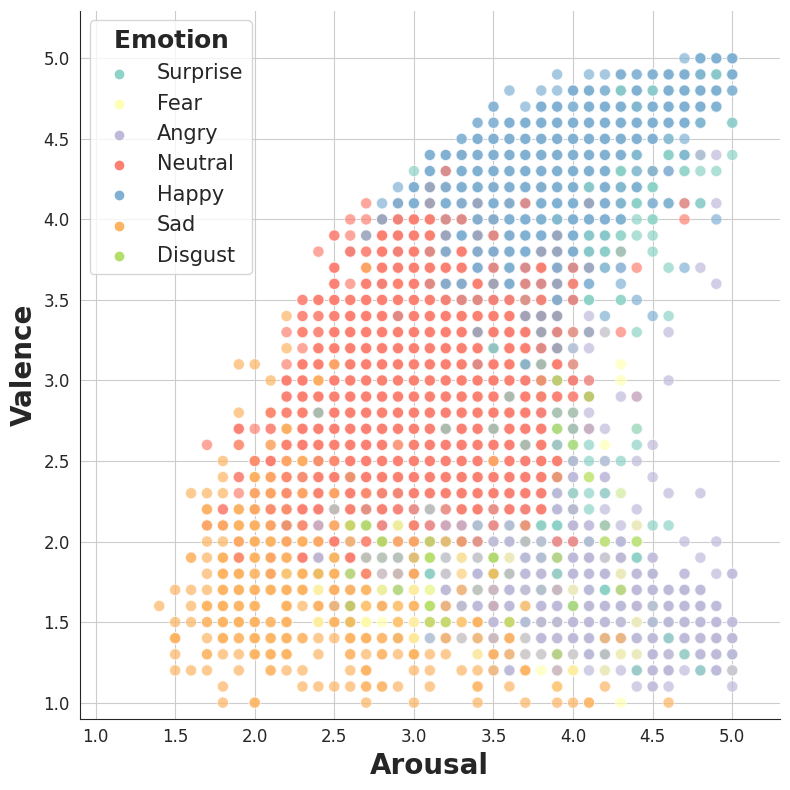

In [8]:

sns.set_style("whitegrid")

color_palette = sns.color_palette("Set3")
label_fsize = 20
ticks_fsize = 12
legend_size = 15
plt.rcParams["axes.edgecolor"] = "0.15"

_, ax = plt.subplots(figsize=(8, 8))

ax = sns.scatterplot(x='arousal', y='valence', data=onehot_df, 
                     hue="emotion",
                     palette = color_palette,
                     s=65,
                         alpha=0.7)
ax.set_xlim((0.9, 5.3))
ax.set_ylim((0.9, 5.3))
ax.legend()

ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.legend(
            loc='best',
           fontsize=legend_size,title=r'$\bf{Emotion}$',frameon=True,
           fancybox=True ,
           title_fontsize=18,
           )
plt.xlabel('Arousal', fontweight='bold', fontsize=label_fsize)
plt.ylabel('Valence', fontweight='bold', fontsize=label_fsize)
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.tight_layout()
# plt.savefig('./etri-eda_total.svg')
plt.show()

/tmp/ipykernel_1565232/1627064417.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(y_ticks_, size = ticks_size)
/tmp/ipykernel_1565232/1627064417.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(y_ticks_, size = ticks_size)
/tmp/ipykernel_1565232/1627064417.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(y_ticks_, size = ticks_size)


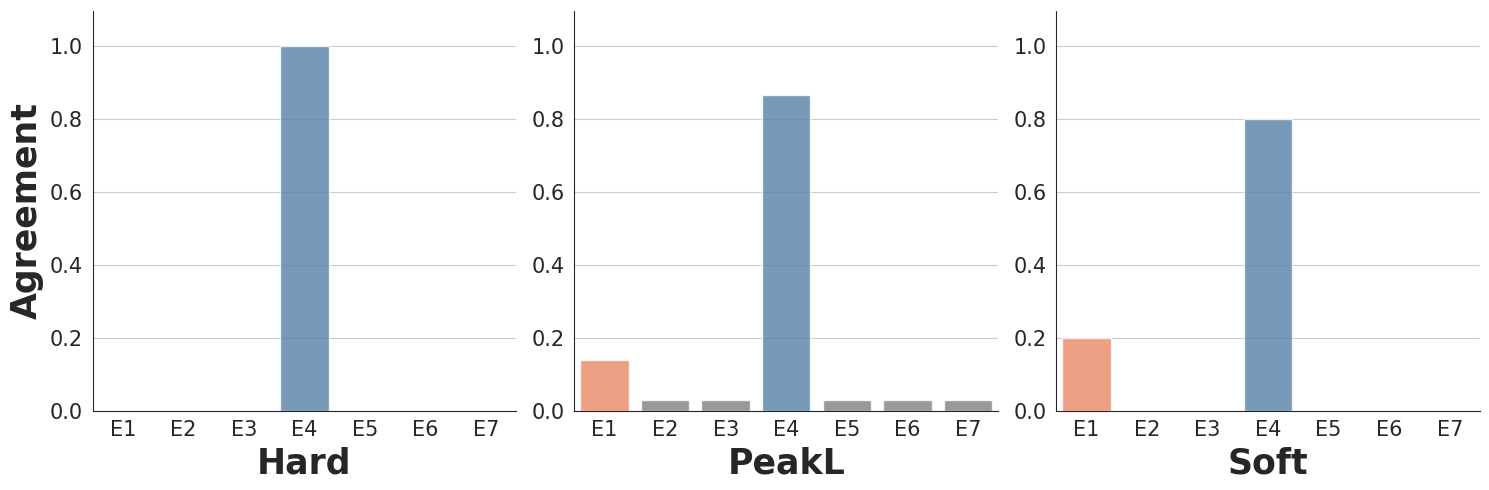

In [9]:
sns.set_style("whitegrid")
x = [f'E{i}' for i in range(1,7+1)]
y_hard = [0, 0, 0, 1, 0, 0, 0]
y_soft = [0.2, 0, 0, 0.8, 0, 0, 0]
y_ppeakl = [0.1393, 0.03, 0.03, 0.8657, 0.03, 0.03, 0.03]




mpl.rc('axes', labelsize=25, titlesize=16)

y_ticks_ = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
label_size = 25
ticks_size = 15
ALPHA = 0.8
plt.rcParams["axes.edgecolor"] = "0.15"

fig, axes = plt.subplots(figsize=(15,5),nrows=1, ncols=3)
ax1 = sns.barplot(x=x, y=y_hard, ax=axes[0], 
                  alpha=ALPHA,
                  color='steelblue')
ax1.set(ylim=(0, 1.1))
ax1.set_xlabel("Hard",fontsize=label_size,  fontweight='bold')
ax1.set_ylabel("Agreement",fontsize=label_size ,  fontweight='bold')
ax1.set_yticklabels(y_ticks_, size = ticks_size)
ax1.set_xticklabels(x, size = ticks_size)
ax1.spines['right'].set_color(None)
ax1.spines['top'].set_color(None)

ax2 = sns.barplot(x=x, y=y_ppeakl, ax=axes[1],
                  alpha=ALPHA,
                      palette=['coral','gray','gray','steelblue','gray','gray','gray'])
ax2.set(ylim=(0, 1.1))
ax2.set_xlabel("PeakL",fontsize=label_size, y=-5,  fontweight='bold')
ax2.set_yticklabels(y_ticks_, size = ticks_size)
ax2.set_xticklabels(x, size = ticks_size)
ax2.spines['right'].set_color(None)
ax2.spines['top'].set_color(None)

ax3 = sns.barplot(x=x, y=y_soft, ax=axes[2], 
                  alpha=ALPHA,
                palette=['coral','steelblue','steelblue','steelblue','steelblue','steelblue','steelblue'])
ax3.set(ylim=(0, 1.1))
ax3.set_xlabel("Soft",fontsize=label_size,  fontweight='bold')
ax3.set_yticklabels(y_ticks_, size = ticks_size)
ax3.set_xticklabels(x, size = ticks_size)
ax3.spines['right'].set_color(None)
ax3.spines['top'].set_color(None)


plt.tight_layout()
# plt.savefig('./etri-fig_ppeak.svg')
plt.show()